In [1]:
# Goal: Investigate the arnett peak using the vanilla variation of it
import sys
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numba
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
import astropy.table as table
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import seaborn
import tqdm
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.const as const
import snelib19odp.utils as utils
import snelib19odp.tigerfit as tigerfit
import snelib19odp.analysis.arnett as arnett

In [2]:
%timeit arnett.luminosity_nico(10, 0.2, 10, 3)

5.54 µs ± 81.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [3]:
ds = dataset.load_dataset('SN2002ap')

In [4]:
# Params
#texpl_range = (56458.3-0.8, 56459.27)
texpl_range = (52296.5, 52303)
time_range = (ds.transient.prior_t0 - 16, ds.transient.prior_t0+25)
prior_kwargs = {
#    'vej_min': 9477,
#    'vej_max': 12347,
#    'gamma_trapped': True
}
time_valid = np.array([
    [52303, 52356],
])

In [5]:
sampler_w = arnett.nested_fitting(ds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid)
sampler = sampler_w.sampler

  0%|          | 0/12000 [00:00<?, ?it/s]/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
100%|██████████| 12000/12000 [00:30<00:00, 394.32it/s]


Text(0.5, 0, 'Phase [d]')

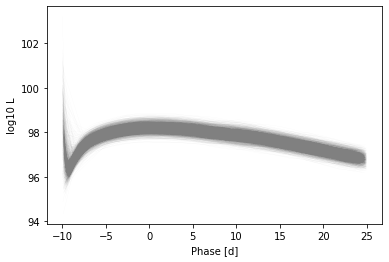

In [6]:
for i in range(min(3000, sampler_w.pregen_times.shape[0])):
    pregen_t = sampler_w.pregen_times[i,:]
    pregen_l = sampler_w.pregen_lums[i,:]
    x = table.Table({'t': pregen_t, 'l': pregen_l})
    x.sort('t')
    plt.plot(x['t'] - ds.transient.prior_t0, x['l'], color='grey', alpha=0.1, lw=0.1)
plt.ylabel('log10 L')
plt.xlabel('Phase [d]')

In [7]:
sampler.run_nested(dlogz=0.25)#dlogz_init=0.5)
main_results = sampler.results

6118it [06:00, 16.99it/s, +500 | bound: 536 | nc: 1 | ncall: 511321 | eff(%):  1.294 | loglstar:   -inf < -0.912 <    inf | logz: -11.785 +/-  0.191 | dlogz:  0.001 >  0.250]


In [8]:
dyplot.cornerplot(sampler.results, labels=['Mni', 't_d', 't_expl'], show_titles=True);

In [9]:
results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)

array([2.53951497, 3.35239243])

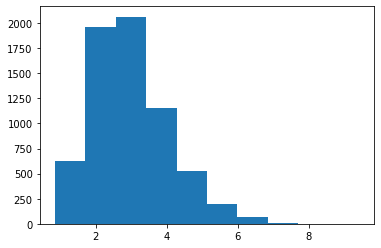

In [10]:
t_d = trace[:,1] * u.day.to(u.s)
xi = np.pi**2 / 3  # Arnett
# xi = 1 # one-zone model
opacity = 0.07
c = aconst.c.cgs.value
v_ej = 10912 * u.km.to(u.cm)/np.sqrt(0.6)
m_ej = t_d**2 * 4 * np.pi / 3 * v_ej * c * xi / opacity * u.g.to(u.Msun)
plt.hist(m_ej);
np.percentile(m_ej, [38, 68])

In [11]:
tmins = np.array([14, 12, 10])
tmaxs = np.array([10, 15, 20, 25, 27])
for t_min in tmins:
    results = []
    for t_max in tmaxs:
        while True:
            try:
                time_range = (ds.transient.prior_t0 - t_min, ds.transient.prior_t0+t_max)
                sampler_w = arnett.nested_fitting(ds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid)
                sampler = sampler_w.sampler
                sampler.run_nested()#dlogz_init=0.25)
                break
            except:
                continue
        results.append(sampler.results)
    logz = [result.logz[-1] for result in results]
    plt.plot(tmaxs, logz, label='t_min=%d' % t_min)
plt.legend()

100%|██████████| 12000/12000 [00:30<00:00, 393.97it/s]
4942it [01:38, 49.98it/s, +500 | bound: 174 | nc: 1 | ncall: 161650 | eff(%):  3.367 | loglstar:   -inf < -0.143 <    inf | logz: -9.323 +/-  0.191 | dlogz:  0.001 >  0.509]
100%|██████████| 12000/12000 [00:30<00:00, 396.15it/s]
4997it [01:18, 63.68it/s, +500 | bound: 140 | nc: 1 | ncall: 136986 | eff(%):  4.013 | loglstar:   -inf < -0.127 <    inf | logz: -9.408 +/-  0.190 | dlogz:  0.001 >  0.509]
100%|██████████| 12000/12000 [00:30<00:00, 393.33it/s]
5202it [01:58, 44.07it/s, +500 | bound: 217 | nc: 1 | ncall: 206205 | eff(%):  2.765 | loglstar:   -inf < -0.091 <    inf | logz: -9.840 +/-  0.190 | dlogz:  0.001 >  0.509]
100%|██████████| 12000/12000 [00:30<00:00, 395.28it/s]
5580it [03:47, 24.54it/s, +500 | bound: 418 | nc: 1 | ncall: 394008 | eff(%):  1.543 | loglstar:   -inf < -1.168 <    inf | logz: -11.719 +/-  0.208 | dlogz:  0.001 >  0.509]
100%|██████████| 12000/12000 [00:30<00:00, 391.57it/s]
6078it [07:54, 12.80it/s, +5

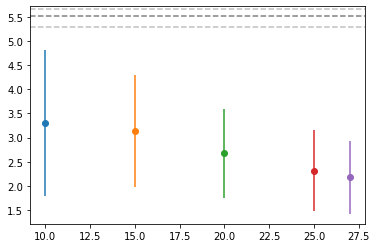

In [12]:
for t_max, result in zip(tmaxs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    
    t_d = trace[:,1] * u.day.to(u.s)
    xi = np.pi**2 / 3  # Arnett
    # xi = 1 # one-zone model
    opacity = 0.07
    c = aconst.c.cgs.value
    v_ej = 10912 * u.km.to(u.cm)
    m_ej = t_d**2 * 4 * np.pi / 3 * v_ej * c * xi / opacity * u.g.to(u.Msun)
    plt.errorbar(t_max, np.nanmean(m_ej), yerr=np.nanstd(m_ej), marker='o')
plt.axhline(5.51, ls='--', color='grey')
plt.axhline(5.51-0.22, ls='--', alpha=0.5, color='grey')
plt.axhline(5.51+0.15, ls='--', alpha=0.5, color='grey');

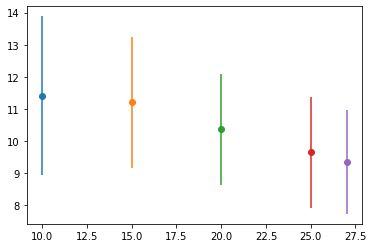

In [13]:
for t_max, result in zip(tmaxs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    t_d = trace[:,1]
    plt.errorbar(t_max, np.nanmean(t_d), yerr=np.nanstd(t_d), marker='o')

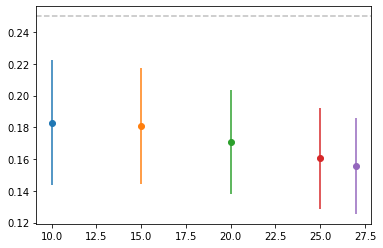

In [14]:
for t_max, result in zip(tmaxs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    m_ni = trace[:,0]
    plt.errorbar(t_max, np.nanmean(m_ni), yerr=np.nanstd(m_ni), marker='o')
plt.axhline(0.25, ls='--', alpha=0.5, color='grey')

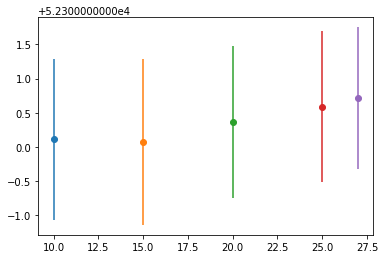

In [15]:
for t_max, result in zip(tmaxs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    texpl = trace[:,2]
    plt.errorbar(t_max, np.nanmean(texpl), yerr=np.nanstd(texpl), marker='o')

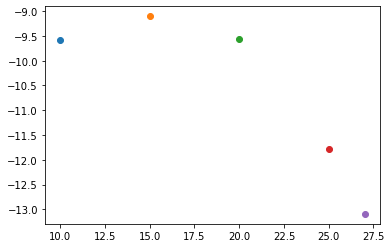

In [16]:
for t_max, result in zip(tmaxs, results):
    logz = result.logz[-1]
    plt.scatter(t_max, logz, marker='o')

In [17]:
texpl_errs = np.array([0.1, 1.0, 2.0, 4.0])
results = []
t_max = 40
for texpl_err in texpl_errs:
    texpl_range = (56458.67 - texpl_err/2, 56458.67+texpl_err/2)
    time_range = (ds.transient.prior_t0 - 14, ds.transient.prior_t0+t_max)
    sampler = arnett.nested_fitting(ds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid)
    sampler.run_nested()#dlogz_init=0.25)
    results.append(sampler.results)

100%|██████████| 12000/12000 [00:30<00:00, 392.63it/s]
../lib/snelib19odp/analysis/arnett.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return np.log(pre_factor * integral)


AttributeError: 'SamplerWrapper' object has no attribute 'run_nested'

In [ ]:
for texpl_err, result in zip(texpl_errs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    
    t_d = trace[:,1] * u.day.to(u.s)
    xi = np.pi**2 / 3  # Arnett
    # xi = 1 # one-zone model
    opacity = 0.07
    c = aconst.c.cgs.value
    v_ej = 10912 * u.km.to(u.cm)
    m_ej = t_d**2 * 4 * np.pi / 3 * v_ej * c * xi / opacity * u.g.to(u.Msun)
    plt.errorbar(texpl_err, np.nanmean(m_ej), yerr=np.nanstd(m_ej), marker='o')
#plt.axhline(5.51, ls='--', color='grey')

In [ ]:
t_grid = ds.transient.prior_t0 + np.linspace(-16, 50)
bolometric_method = 'lyman'
for i in range(500):
    lc = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['correlated-error'])
    lums = np.log(utils.convert_luminosity(lc))
    #plt.plot(t_grid, lums, alpha=0.02, color='blue')

samples, weights = main_results.samples, np.exp(main_results.logwt - main_results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)
modfunc = np.vectorize(arnett.luminosity_nico)
for i in range(500):
    x = trace[i*10 % trace.shape[0]]
    lums = modfunc(t_grid, *x)
    plt.plot(t_grid, lums, alpha=0.02, color='orange')

In [ ]:
t_grid = ds.transient.prior_t0 + np.linspace(-16, 30)
bolometric_method = 'lyman'
for i in range(500):
    lc = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['correlated-error'])
    lums = np.log(utils.convert_luminosity(lc))
    #plt.plot(t_grid, lums - lums[13], alpha=0.02, color='blue')
    plt.plot(t_grid, lums - np.percentile(lums, 95), alpha=0.02, color='blue')

samples, weights = main_results.samples, np.exp(main_results.logwt - main_results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)
modfunc = np.vectorize(arnett.luminosity_nico)
for i in range(500):
    x = trace[i*10 % trace.shape[0]]
    #x[2] = 58714.5
    lums = modfunc(t_grid, *x)
    #plt.plot(t_grid, lums - lums[13], alpha=0.02, color='orange')
    plt.plot(t_grid, lums - np.percentile(lums, 95), alpha=0.02, color='orange')